# 1 and 2 

# Select images for Experiment 1

Steps:

1. Download aligned and cropped face dataset off of kaggle, get familiarised with it. Images are labelled with metadata: [age] _ [gender] _ [race] _ [date&time] .

2. Decide on a facial feature that the test participants will rate in Experiment 1. We have decided to do: Happy/Sad 26 year-old black women.

3. Select an initial subset of approximately 300 images for Experiment 1. Use Excel-file UTKFace_Info.xlsx as help. Update https://docs.google.com/spreadsheets/d/15q9CGJnwyNy_7i_-u31AWPhznXJPHpOr4EuCGV_GIzw/edit?usp=sharing with research question.

4. Conduct manual quality control and discard images that do not have a high resolution or do not contain a full-frontal photo of a face. Also keep an eye out for salient water marks. Minimum 200 images should remain after quality control!

5. Finally, gray-scale the images and consider if you want to reduce the dimensionality of the images using cropping and down-sampling.

In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("abhikjha/utk-face-cropped")

print("Path to dataset files:", path)

Path to dataset files: /Users/viraj.rajurkar/.cache/kagglehub/datasets/abhikjha/utk-face-cropped/versions/1


This section was written by Viraj to select the images that Mustafa and Anka chose.

In [ ]:
#Taking Mustafa and Anka's list and selecting the 280 images that they chose.

import pandas as pd
from pathlib import Path
import shutil

# === CONFIG ===
images_dir = Path("/Users/viraj.rajurkar/Desktop/CogModData")     
ratings_file = Path("/Users/viraj.rajurkar/Cognitive-Modelling-Project/newfiltered (1).txt")       
out_dir = Path("/Users/viraj.rajurkar/Cognitive-Modelling-Project/processed_data")                 # folder where extracted images go

# === SETUP ===
out_dir.mkdir(exist_ok=True)

# Load teammates’ list (filename, r1, r2)
df = pd.read_csv(ratings_file, header=None, names=["filename", "r1", "r2"])
filenames = df["filename"].str.strip().tolist()

# Match and copy
found, missing = [], []
for fname in filenames:
    img_path = images_dir / fname
    if img_path.exists():
        shutil.copy2(img_path, out_dir / fname)
        found.append(fname)
    else:
        missing.append(fname)

print(f"Copied {len(found)} images to {out_dir}")
if missing:
    print(f"Missing {len(missing)} images (examples: {missing[:5]})")


Copied 280 images to /Users/viraj.rajurkar/Cognitive-Modelling-Project/processed_data


Pre-processing of images.

1. Gray-scale the images. Take the RGB nonsense (3 dimensions already) of the images and make it gray (1 dimension). This won't affect how the images are perceived as "happy", because RGB doesn't really affect the perception of happiness.

2. Crop the images for unwanted excess.

3. Reduce the dimensionality to something appropriate like 64x64. This seems to be standard in simple image processing tasks like ours. This'll also greatly reduce dimensionality while preserving information!

In [3]:
from pathlib import Path
from PIL import Image
import numpy as np
import pandas as pd

# Config files and target size
in_dir = Path("processed_data")         # folder with Anka and Mustafa's ~280 chosen images
out_dir = Path("processed_64x64_gray") # where processed images & arrays go
target_size = (64, 64)                 # down-sampled size (64,64)

# Setup
out_dir.mkdir(parents=True, exist_ok=True)
valid_exts = {".jpg"}

def center_square_crop(img: Image.Image) -> Image.Image:
    """Center-crop to a square using the min dimension (keeps face centered)."""
    w, h = img.size
    side = min(w, h)
    left = (w - side) // 2
    top = (h - side) // 2
    return img.crop((left, top, left + side, top + side))

def process_one(path: Path, target_size=(64,64)) -> Image.Image:
    img = Image.open(path).convert("RGB")   # normalize mode
    gray = img.convert("L")                  # grayscale (1 channel)
    cropped = center_square_crop(gray)       # safe center square crop
    resized = cropped.resize(target_size, Image.BILINEAR)  # down-sample
    return resized

# Pre-processing 
files = sorted([p for p in in_dir.iterdir() if p.suffix.lower() in valid_exts])
X = []
kept_names = []

for src in files:
    try:
        out_img = process_one(src, target_size=target_size)
        # save processed image (same filename) for easy visual checks
        out_path = out_dir / src.name
        out_img.save(out_path)
        # add to matrix (flatten to 1D vector for PCA later)
        X.append(np.array(out_img, dtype=np.float32).ravel())
        kept_names.append(src.name)
    
    except Exception as e:
        print(f"Skip {src.name}: {e}")

X = np.stack(X) if X else np.empty((0, target_size[0]*target_size[1]), dtype=np.float32)

# Save artifacts
np.save(out_dir / "X.npy", X)  # shape: (N, H*W) e.g., (280, 4096) for 64x64
pd.Series(kept_names, name="filename").to_csv(out_dir / "filenames.csv", index=False)

print("Done.")
print("Processed images folder:", out_dir)
print("X.npy shape:", X.shape)
print("Example: each row is one grayscale image flattened to", target_size[0]*target_size[1], "pixels.")


Done.
Processed images folder: processed_64x64_gray
X.npy shape: (280, 4096)
Example: each row is one grayscale image flattened to 4096 pixels.


In [ ]:
# Experiment 1: Per-participant ratings

from pathlib import Path
from IPython.display import display, Image as IPyImage
from PIL import Image
import random, csv, json
from collections import defaultdict, Counter
import os

# Configs
STUDENT_ID = "s215221"                       # 
IMAGE_DIR  = Path("processed_64x64_gray")    # <-- folder containing your 280 grayscale images
OUTPUT_DIR = Path("exp1_outputs")            # where logs/CSVs will be saved
VALID_EXTS = {".jpg"}
RATING_MIN, RATING_MAX = 1, 5
# ----------------------------------------

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
trial_log_path = OUTPUT_DIR / f"{STUDENT_ID}_trial_log.txt"   # per-trial log (append as you go)
final_csv_path = OUTPUT_DIR / f"{STUDENT_ID}.txt"             # final file: filename,rating1,rating2
manifest_path  = OUTPUT_DIR / f"{STUDENT_ID}_manifest.json"

# Gathering images
files = sorted([p for p in IMAGE_DIR.iterdir() if p.suffix.lower() in VALID_EXTS])
if not files:
    raise RuntimeError(f"No images found in {IMAGE_DIR}. Check IMAGE_DIR and extensions.")

# Build/resume trials: each filename appears twice
# We'll use a trial-level log to support resuming.
def load_trial_log(path):
    rows = []
    if path.exists():
        with open(path, "r", newline="", encoding="utf-8") as f:
            reader = csv.DictReader(f)
            for r in reader:
                rows.append(r)
    return rows

def save_trial_row(path, row, write_header_if_new=True):
    file_exists = path.exists()
    with open(path, "a", newline="", encoding="utf-8") as f:
        writer = None
        if write_header_if_new and not file_exists:
            writer = csv.DictWriter(f, fieldnames=["trial_index","filename","rating"])
            writer.writeheader()
        writer = csv.DictWriter(f, fieldnames=["trial_index","filename","rating"])
        writer.writerow(row)

# Count how many ratings already collected per image (0, 1, or 2)
existing = load_trial_log(trial_log_path)
count_per_image = Counter([r["filename"] for r in existing])

# Create full list of required trials (2 per filename), then drop ones already completed (2)
required_trials = []
for p in files:
    needed = 2 - count_per_image[p.name]
    if needed > 0:
        required_trials.extend([p.name]*needed)

# Randomize order of remaining trials
random.shuffle(required_trials)

print(f"Images in folder: {len(files)}")
already_done = sum(min(2, count_per_image[p.name]) for p in files)
print(f"Ratings already logged (resume): {already_done} / {len(files)*2}")
print(f"Trials remaining this run: {len(required_trials)}")

# Looping to see images and collect ratings
trial_index_start = len(existing)
for i, fname in enumerate(required_trials, start=trial_index_start):
    img_path = IMAGE_DIR / fname
    # Display in notebook
    display(IPyImage(filename=str(img_path)))
    # Input with validation
    while True:
        raw = input(f"[{i+1}/{len(files)*2}] Rate {fname} on {RATING_MIN}-{RATING_MAX} (or 'q' to quit): ").strip()
        if raw.lower() in {"q","quit","exit"}:
            print("Stopping early. Progress saved. Re-run this cell later to resume.")
            raise SystemExit
        try:
            rating = int(raw)
            if RATING_MIN <= rating <= RATING_MAX:
                break
            else:
                print(f"Please enter an integer between {RATING_MIN} and {RATING_MAX}.")
        except:
            print("Please enter a valid integer.")

    # Save a trial row right away (failsafe for crashes/interrupts)
    save_trial_row(trial_log_path, {
        "trial_index": i,
        "filename": fname,
        "rating": rating
    })

print("All trials completed for this participant.")

# Build the final per-participant CSV: filename, rating1, rating2
# Preserve the order the two ratings were recorded for each image.
trial_rows = load_trial_log(trial_log_path)
by_file = defaultdict(list)
for r in trial_rows:
    by_file[r["filename"]].append(int(r["rating"]))
# only keep first two ratings (there should be exactly 2)
for k in by_file:
    by_file[k] = by_file[k][:2]

# Verify completeness
incomplete = [k for k, v in by_file.items() if len(v) != 2]
if incomplete:
    print("Warning: these images do not have 2 ratings yet:", incomplete[:10])

# Write final CSV
with open(final_csv_path, "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["filename","rating1","rating2"])
    for p in files:  # keep a stable order by filename
        r = by_file.get(p.name, [])
        if len(r) == 2:
            writer.writerow([p.name, r[0], r[1]])

print(f"Saved final CSV: {final_csv_path}")
# print(f"(Per-trial log kept at {trial_log_path} for auditing/resume.)")


Histogram for Anka and Mustafa (Experiment 1)

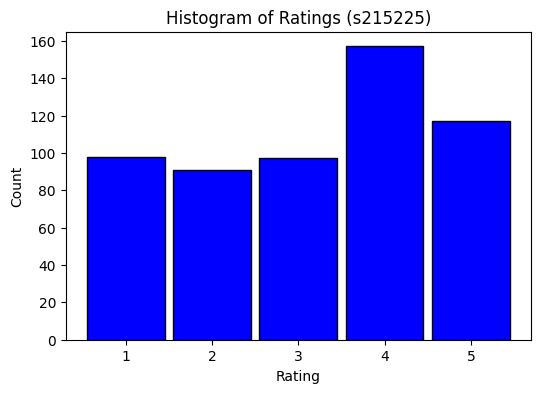

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the .txt as CSV
df = pd.read_csv("exp1_outputs/s215225.txt")

# Combine rating1 and rating2 into a single series
all_ratings = pd.concat([df["rating1"], df["rating2"]], ignore_index=True)

# Plot histogram
plt.figure(figsize=(6,4))
plt.hist(all_ratings, bins=[0.5,1.5,2.5,3.5,4.5,5.5], rwidth=0.9, color="blue", edgecolor="black")
plt.xticks([1,2,3,4,5])
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Histogram of Ratings (s215225)")
plt.show()

Histogram for Viraj (Experiment 1)

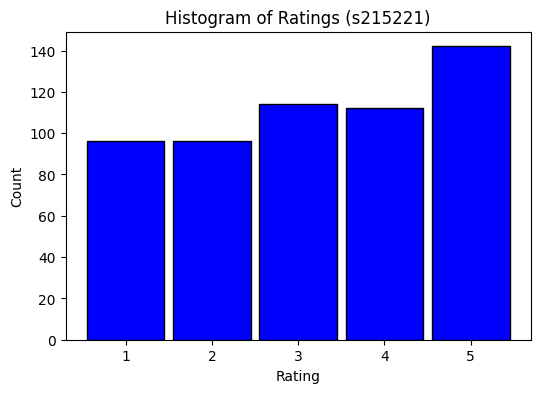

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the .txt as CSV
df = pd.read_csv("exp1_outputs/s215221.txt")

# Combine rating1 and rating2 into a single series
all_ratings = pd.concat([df["rating1"], df["rating2"]], ignore_index=True)

# Plot histogram
plt.figure(figsize=(6,4))
plt.hist(all_ratings, bins=[0.5,1.5,2.5,3.5,4.5,5.5], rwidth=0.9, color="blue", edgecolor="black")
plt.xticks([1,2,3,4,5])
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Histogram of Ratings (s215221)")
plt.show()

------------------------------------------------------------------------------------------

The following sections are written as part of Experiment 1 by Mustafa and Anka

In [ ]:
# Basically find the images containing 26 year old black women

import os

folder = os.listdir(path)[0]
folder = os.path.join(path, folder)
print("Folder with path:", folder)
black_women = [image for image in os.listdir(folder) if "26_1_1_" in image]
print("Number of black women:", len(black_women))


# Copy files to a new folder
import shutil
new_folder = "data"
for image in black_women:
    src = os.path.join(folder, image)
    dst = os.path.join(new_folder, image)
    shutil.copy(src, dst)

In [ ]:
# Basically manual annotation of images ... needs work loll!
ratings = dict([(image, 0) for image in black_women])
from IPython.display import Image, display

num_images = len(ratings)
current_image = 0
deleted = 0
rated_images =[]
with open("ratings.txt", "r") as f:
    for line in f:
        image, rating = line.strip().split(", ")
        rated_images.append(image)
        current_image += 1
        if rating == "-1":
            deleted += 1

for image in ratings.keys():
    if image in rated_images:
        continue
    display(Image(filename=os.path.join(new_folder, image)))
    rating = input(f"Rate the attractiveness of the person in {image} (0-10): ") ### red flag
    ratings[image] = int(rating)
    current_image += 1
    with open("ratings.txt", "a") as f:
        f.write(f"{image}, {rating}\n")
    print(f"Progress: {current_image}/{num_images} images rated.")
    if rating == "-1":
        deleted += 1
        print(f"Total deleted: {deleted}")

In [ ]:
# Checks how many times each ratinfg was given in... like how many 1s, 2s, etc!

ratings = []

with open("ratings.txt", "r") as f:
    for line in f:
        image, rating = line.strip().split(", ")
        ratings.append((image, int(rating)))

# frequency of each rating
from collections import Counter
rating_counts = Counter([rating for image, rating in ratings])
print("Rating counts:", rating_counts)